# Wstęp do Sztucznej Inteligencji - rok akademicki 2017/2018

Przed rozpoczęciem pracy z notatnikiem zmień jego nazwę zgodnie z wzorem: `{NrAlbumu}_{Nazwisko}_{Imie}_{PoprzedniaNazwa}`.

Przed wysłaniem notatnika upewnij się, że rozwiązałeś wszystkie zadania/ćwiczenia, w szczególności, że uzupełniłeś wszystkie pola `YOUR CODE HERE` oraz `YOUR ANSWER HERE`. Możesz również sprawdzić czy twoje rozwiązania przechodzą wstępną walidację (Validate). 

## Temat: Algorytmy genetyczne - Lab 3
Zapoznaj się z treścią niniejszego notatnika czytając i wykonując go komórka po komórce. Wykonaj napotkane zadania/ćwiczenia.

## Zadanie 1

Zgodnie z instrukcjami prowadzącego, wybierz funkcję testową ze strony: https://www.sfu.ca/~ssurjano/optimization.html z działu "Many Local Minima" (z wyjątkiem funkcji nr 6).

Zaplementuj ją jako funkcję w Pythonie.

Dla wszystkich funkcji przyjmujemy `N`=2 tzn. rozważamy ją jako funkcję dwóch zmiennych $f(x_1, x_2)$.

In [43]:
import math
import numpy as np

# testowa funkcja celu
# x - jednowymiarowa tablica ndarray
def obj_func(xx):
    
    d=len(xx);
    
    w=[1 + (xx[ii] - 1)/4 for ii in range(0,d)]
    term1 = np.sin(math.pi*w[0])**2 
    term3 = (w[d-1]-1)**2 * (1+(np.sin(2*math.pi*w[d-1]))**2)
    
    suma=0;
    
    for ii in range(0,d-1):
        wi=w[ii]
        new = (wi -1)**2 * (1+10*(np.sin(math.pi*wi+1))**2)
        suma = suma + new
    y=term1+suma+term3
    return(y)


print(obj_func([2,5,4]))

10.3648896286


## Zadanie 2

Przygotuj wykres 3D funkcji zaimplementowanej w zadaniu nr 1.

<IPython.core.display.Javascript object>


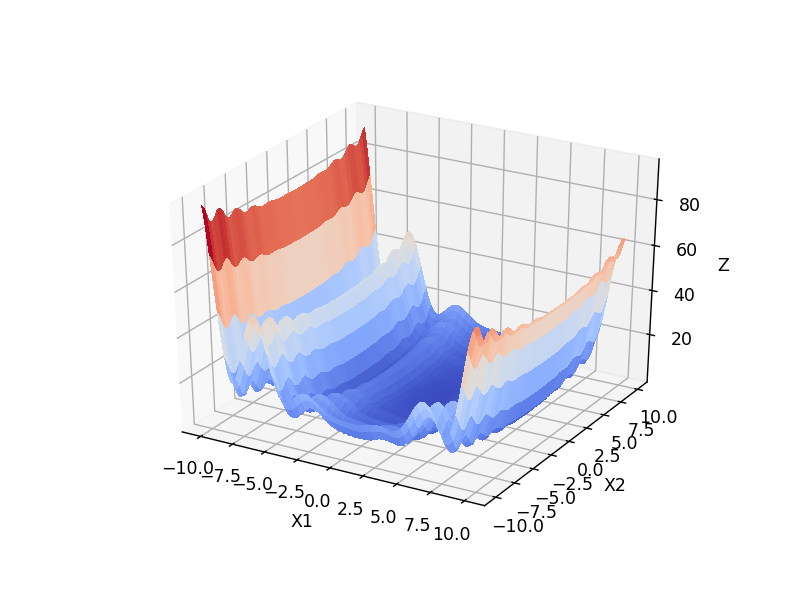

In [48]:
import math

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d


p = np.linspace(-10.0, 10.0, 200)
X1, X2 = np.meshgrid(p, p)
Z = np.zeros((len(p), len(p)))
for i in range(len(p)):
    for j in range(len(p)):
        Z[i, j] = obj_func([X1[i, j], X2[i, j]])

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Z')

plt.show()


## Zadanie 3

Korzystając z funkcji zaimplementowanych na poprzednich zajęciach, zaimplementuj główną pętlę klasycznego algorytmu genetyczengo.
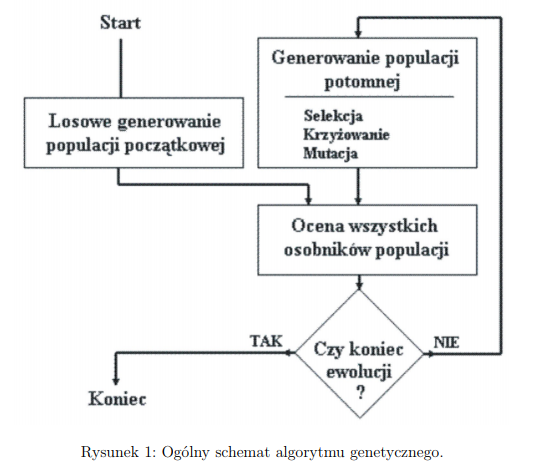

Implementacja powinna mieć postać funkcji, która przyjmuje parametry:

- `fun` - funkcja, której maksimum ma zostać znalezione
- `pop_size` - rozmiar populacji
- `pk` - prawdopodobieństwo krzyżowania
- `pm` - prawdopodobieństwo mutacji
- `generations` - liczba pokoleń 
- `dx` - dokładność kodowania

Funkcja powinna zwracać:
- `best_sol` - najlepsze znalezione rozwiązanie (nieważne, w której iteracji; UWAGA! niekoniecznie jest to najlepszy osobnik z ostatniej populacji)
- `best_generation` - numer pokolenia, z którego pochodzi najlepsze rozwiązanie
- `list_best` - lista z najlepszą oceną osobnika w każdym pokoleniu (najlepsza ocena znaleziona w danym pokoleniu lub wcześniej)
- `list_best_generation` - lista z najlepszymi ocenami w każdym pokoleniu (najlepsza ocena z danej populacji)
- `list_mean` - lista z wartościami średnimi ocen osobników z każdego pokolenia

In [51]:
import math
import numpy as np

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def gen_population(P, N, B):
    w=(P, N * B)
    pop = np.random.randint(2, size=w) 
    return pop


def roulette(pop, evaluated_pop):
    # czy populacja nie jest pusta??????
    if pop.size < 1:
        raise ValueError("Populacja musi liczyć przynajmniej 1 osobnika")
    
    new_pop = np.empty(pop.shape, dtype=int)
    
   
    min = evaluated_pop.min()
    if min <= 0:
        evaluated_pop += np.abs(min) + 1 #Ocena>0
    
    suma = evaluated_pop.sum()
    
    #sprawdzamy prawdopodobieństwo
    roz = np.array([x / suma for x in evaluated_pop])
    dyst = np.cumsum(roz)
   
    for i in range(pop.shape[0]):
        random = np.random.random()
        for j in range(pop.shape[0]): # powyżej progu
            if dyst[j] >= random: 
                new_pop[i] = pop[j]
                break

    return new_pop

def evaluate_population(func, pop, N, B, a, dx):
    #list comprehension
    evaluated_pop = np.array([func(decode_individual(x,N,B,a,dx)) for x in pop])
        
    return evaluated_pop

def nbits(a, b, dx): 
    x = (b-a)/dx+1
    y = 0
    while x > 1:
        x = x/2
        y += 1
    return (y, (b-a) / ((2 ** y) - 1))


def get_best(pop, evaluated_pop):    
    best_individual = pop[np.argmax(evaluated_pop)]
    best_value = np.max(evaluated_pop)
    return best_individual, best_value


def decode_individual(individual, N, B, a, dx):
     
    decode_individual = []
    for i in range(N):
        x = 0;
        for j in range(B):
            if individual[i*B+j] == 1:
                x += 2**(B-1-j)
    
        decode_individual.append(a+dx*x);            
    return np.array(decode_individual)

def cross(pop, pk):   
    if pop.size < 1:
        raise ValueError("Populacja musi liczyć choć 1 osobnika")
    
    new_pop = np.empty(pop.shape, dtype=int) 
    prawd = np.random.random(pop.shape[0]) 
    
    for i in range(pop.shape[0]): 
        if(prawd[i] < pk): #powyżej progu prawd
            krzprawd = np.random.randint(1, pop.shape[0] - 1) 
            new_pop[i] = np.append(pop[i][0:krzprawd:], pop[(i + 1)%(pop.shape[0])][krzprawd::])
        else:
            new_pop[i] = pop[i]
            
    return new_pop

#symulacja mutowania biologicznego
def mutate(pop, pm):
    if pop.size < 1:
        raise ValueError("W populacji musi być co najmniej jeden osobnik")
    #praca na kopii
    new_pop = pop 
    
    for i in range(new_pop.shape[0]):
        for j in range(new_pop.shape[1]):
            if np.random.random() < pm: 
                new_pop[i][j] ^= 1 #Zamiana bitu             
    
    return new_pop


def evolve(fun, pop_size, pk, pm, generations, dx):
    PoczatekPrzedzialu = -5.12
    KoniecPrzedzialu = 5.12
    N = 2
    
    B, dx = nbits(PoczatekPrzedzialu, KoniecPrzedzialu, dx)
    
    #generuj populacje
    pop = gen_population(pop_size, N, B)
    
    #ocena osobniki
    evaluated_pop = evaluate_population(fun, pop, N, B, PoczatekPrzedzialu, dx)
    
   
    start_pop_decoded = np.apply_along_axis(decode_individual, 1, pop, N, B, PoczatekPrzedzialu, dx) #uzyskanie wartosci zmiennych z kodów
    start_pop_evaluated = np.copy(evaluated_pop) # wartosci funkcji dla populacji
    middle = np.ceil(generations/2) - 1 #indeks środkowej generacji
    last = generations - 1 #indeks ostatniej generacji
    
    
    #znajdz i zapamietaj najlepsze rozwiazanie
    best_sol = get_best(pop, evaluated_pop)  
    best_generation = 0
    
    #uaktualnij listy statystyk
    list_best = np.array(best_sol[1]) #lista najlepszych wartosci jak dotad
    list_best_generation = np.array(best_sol[1]) #lista najlepszych wartosci z populacji
    list_mean = np.array(np.mean(evaluated_pop, 0))    
    
    for i in range(generations):
        #selekcja
        pop = roulette(pop, evaluated_pop)
        
        #krzyzowanie
        pop = cross(pop, pk)
        
        #mutacja
        pop = mutate(pop, pm)
        
        #ocen osobniki w populacji
        evaluated_pop = evaluate_population(fun, pop, N, B, PoczatekPrzedzialu, dx)
        
        if i == middle:
            middle_pop_decoded = np.apply_along_axis(decode_individual, 1, pop, N, B, PoczatekPrzedzialu, dx)
            middle_pop_evaluated = np.copy(evaluated_pop)
            
        if i == last:
            last_pop_decoded = np.apply_along_axis(decode_individual, 1, pop, N, B, PoczatekPrzedzialu, dx)
            last_pop_evaluated = np.copy(evaluated_pop)
            
        #znajdz najlepsze rozwiazanie z populacji
        new_best_sol = get_best(pop, evaluated_pop)
        
        #uaktualnij listy statystyk
        # (tylko dla najepszego wyniku z populacji)
        list_best_generation = np.append(list_best_generation, new_best_sol[1])
        
        # zapamietaj najlepsze rozwiazanie, jesli jest lepsze niz dotychczasowe najlepsze
        if np.fabs(new_best_sol[1]) < np.fabs(best_sol[1]):
            best_generation = i + 2
            best_sol = new_best_sol
        
        #uaktualnij listy statystyk
        list_best = np.append(list_best, best_sol[1])
        list_mean = np.append(list_mean, np.mean(evaluated_pop, 0))
      
    
    
    return best_sol, best_generation, list_best, list_best_generation, list_mean, ((start_pop_decoded, start_pop_evaluated),(middle_pop_decoded, middle_pop_evaluated),(last_pop_decoded, last_pop_evaluated))
#raise NotImplementedError()

## Zadnie 4 

Zaprezentuj działanie algorytmu z przykładowymi wartościami parametrów:

- `pop_size`: 60
- `pk`: 0.7
- `pm`: 0.01
- `generations`: 200
- `dx`: 1e-10

Na wykresach funkcji 3D przedstaw położenie osobników z pierwszej populacji, w połowie ewolucji oraz końcowej populacji. Zaznacz wyraźnie położenie najlepszeg rozwiązania.

Na wykresach 2D przedstaw przebieg wartości z list z zebranymi statystykami (listy `list_best`, `list_best_generation`, `list_mean`) w zależności od numeru pokolenia. 

In [ ]:
pop_size = 60
pk = 0.7 
pm = 0.01 
generations = 200 
dx = 1e-10 
PoczatekPrzedzialu = -5.12
KoniecPrzedzialu = 5.12
N = 2
ev = evolve(obj_func, pop_size, pk, pm, generations, dx) #rysuje tez wykresy 3D
    
B, dx = nbits(PoczatekPrzedzialu, KoniecPrzedzialu, dx)
naj_x, naj_y = decode_individual(ev[0][0], N, B, PoczatekPrzedzialu, dx)
naj_z = ev[0][1]

#wykres
fig = plt.figure()
plt.suptitle('Mapa pojedynczego pokolenia (Czerwony - najlepszy globalnie)')
a1 = fig.add_subplot(131, projection='3d') #wykres z lewej, generacja poczatkowa
x = ev[5][0][0].T[0]
y = ev[5][0][0].T[1]
z = ev[5][0][1]
a1.scatter(x, y, z, c=z, cmap='cool', marker='.')
a1.scatter(naj_x, naj_y, naj_z, c='r', s=30, marker='o') #naj marker
plt.title('Pierwsze pokolenie')
plt.axis([-600, 600, -600, 600])
a1.set_xlabel('x')
a1.set_ylabel('y')
a1.set_zlabel('z')
a1.view_init(10, 200)

a2 = fig.add_subplot(132, projection='3d') 
x = ev[5][1][0].T[0]
y = ev[5][1][0].T[1]
z = ev[5][1][1]
a2.scatter(x, y, z, c=z, cmap='cool', marker='.')
a2.scatter(naj_x, naj_y, naj_z, c='r', s=30, marker='o') 
plt.title('Środkowe pokolenie')
plt.axis([-600, 600, -600, 600])
a2.set_xlabel('x')
a2.set_ylabel('y')
a2.set_zlabel('z')
a2.view_init(10, 200)

a3 = fig.add_subplot(133, projection='3d') 
x = ev[5][2][0].T[0]
y = ev[5][2][0].T[1]
z = ev[5][2][1]
a3.scatter(x, y, z, c=z, cmap='cool', marker='.')
a3.scatter(naj_x, naj_y, naj_z, c='r', s=30, marker='o') 
plt.title('Ostatnie pokolenie')
plt.axis([-600, 600, -600, 600])
a3.set_xlabel('x')
a3.set_ylabel('y')
a3.set_zlabel('z')
a3.view_init(10, 200)

plt.show()


x = np.linspace(0, generations, num=(generations+1))
y1 = ev[2] 
y2 = ev[3] 
y3 = ev[4] 

fig, ax = plt.subplots()
ax.plot(x, y1, lw=1.3, c='magenta')
ax.set_title('Globalnie najlepsze rozwiązanie')
ax.set_xlabel('Indeks pokolenia')
ax.set_ylabel('Ocena osobnika')
plt.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(x, y2, lw=1.3, c='mediumslateblue')
ax.set_title('Najlepsza ocena z pokolenia')
ax.set_xlabel('Indeks pokolenia')
ax.set_ylabel('Ocena')
plt.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(x, y3, lw=1.3, c='aqua')
ax.set_title('Średnia ocena z każdego pokolenia')
ax.set_xlabel('Indeks pokolenia')
ax.set_ylabel('Średnia ocena')
plt.grid()
plt.show()
#raise NotImplementedError()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Zadanie 5

Zbadaj wpływ parametrów klasycznego algorytmu genetycznego na jego zdolność znalezienia optymalnego rozwiązania. Dla ułatwienia analizy, zmieniając jeden parametr, zachowaj typowe wartości pozostałych.

1. Jak działa algorytm z typowymi ustawieniami parametrów (jak w zadaniu 4)? Podaj średnią wartość przystosowania znalezionego rozwiązania po wielokrotnym uruchomieniu AG.
2. Czy wydłużenie ewolucji przynosi poprawę czy też następuje "nasycenie"? Porównaj zarówno jak dobre rozwiązanie zostało znalezione jak również w której generacji.
    - `generations`: kilka różnych wartości z przedziału [100, 10000]
3. Czy mutacja jest potrzebna? 
    - `pm` = 0.0
4. Jak działa algorytm bez krzyżowania, z samą mutacją? 
    - `pk` = 0.0
5. Czy lepiej jest dłużej ewoluować mniejszą populację czy krócej większą, jeśli liczba ewaluacji funkcji jest taka sama (np. 2000)?
    - porównaj dwa ustawienia: `pop_size`=20, `generations`=100  vs. `pop_size`=100, `generations`=20.

UWAGA: Powyższe porównania powinny być wykonane na podstawie uśrednionych wyników co najmniej 10 uruchomień algorytmu z danymi parametrami. Podając wyniki podaj średnią z najlepszych znalezionych rozwiązań oraz odchylenie standardowe oraz numer pokolenia, w którym znaleziono rozwiązanie. Mile widziane przedstawienie wyników w tabelach z bibilioteki `pandas`.

In [ ]:
import pandas as pd

exec_num = 10 #lub więcej

#----------------1--------------------#
pop_size = 60 
pk = 0.7 
pm = 0.01 
generations = 200 
dx = 1e-10 

#----------------2--------------------#
generations2 = [100, 500, 1000, 2000, 5000, 8000]

#----------------3--------------------#
pm3 = 0.0

#----------------4--------------------#
pk4 = 0.0

#----------------5--------------------#
pop_size5 = [20, 100]
generations5 = [100, 20]

Zad1 = pd.DataFrame()
Zad2 = []
for i in range(len(generations2)):
    Zad2.append( pd.DataFrame() )
    
Zad3 = pd.DataFrame()
Zad4 = pd.DataFrame()
Zad5_0 = pd.DataFrame()
Zad5_1 = pd.DataFrame()

for i in range(exec_num):
    print("Run: ", i)
    print("  Stage 1")
    ev1 = evolve(obj_func, pop_size, pk, pm, generations, dx)
    Zad1 = Zad1.append( pd.DataFrame([[ ev1[0][1], ev1[1] ]], columns=['Wartość przystosowania', 'Index pokolenia'], index=[i] ) )
    
    print("  Stage 2")
    ev2 = []
    for j in range(len(generations2)):
        print("    Gens: ", generations2[j])
        ev2.append( evolve(obj_func, pop_size, pk, pm, generations2[j], dx) )
        Zad2[j] = Zad2[j].append( pd.DataFrame([[ ev2[j][0][1], ev2[j][1] ]], columns=['Wartość przystosowania', 'Indeks pokolenia'], index=[i] ) )
    
    print("  Stage 3")
    ev3 = evolve(obj_func, pop_size, pk, pm3, generations, dx)
    Zad3 = Zad3.append( pd.DataFrame([[ ev3[0][1], ev3[1] ]], columns=['Wartość przystosowania', 'Indeks pokolenia'], index=[i] ) )
    
    print("  Stage 4")
    ev4 = evolve(obj_func, pop_size, pk4, pm, generations, dx)
    Zad4 = Zad4.append( pd.DataFrame([[ ev4[0][1], ev4[1] ]], columns=['Wartość przystosowania', 'Indeks pokolenia'], index=[i] ) )
    
    print("  Stage 5")
    ev5 = []
    ev5.append( evolve(obj_func, pop_size5[0], pk, pm, generations5[0], dx) )
    Zad5_0 = Zad5_0.append( pd.DataFrame([[ ev5[0][0][1], ev5[0][1] ]], columns=['Wartość przystosowania', 'Indeks pokolenia'], index=[i] ) )
    
    ev5.append(  evolve(obj_func, pop_size5[1], pk, pm, generations5[1], dx) )
    Zad5_1 = Zad5_1.append( pd.DataFrame([[ ev5[1][0][1], ev5[1][1] ]], columns=['Wartość przystosowania', 'Indeks pokolenia'], index=[i] ) )


#----------------1--------------------#
print('1. Ustawienia standardowe')

srednia = Zad1.mean()[0]
odchylenie = Zad1.std()[0]
sredni_idx_pok = Zad1.mean()[1]
odchylenie_idx_pok = Zad1.std()[1]
table = pd.DataFrame([[srednia, odchylenie, sredni_idx_pok, odchylenie_idx_pok]], columns=['Średnia','σ','Średnia indeksu pokolenia','σ indeksu pokolenia'])
display(table)

#----------------2--------------------#
print('2. Wydłużenie ewolucji =? nasycenie')

table = pd.DataFrame()
for i in range(len(generations2)):
    srednia = Zad2[i].mean()[0]
    odchylenie = Zad2[i].std()[0]
    sredni_idx_pok = Zad2[i].mean()[1]
    odchylenie_idx_pok = Zad2[i].std()[1]
    table = table.append( pd.DataFrame([[generations2[i], srednia, odchylenie, sredni_idx_pok, odchylenie_idx_pok]], columns=['Ilosc generacji', 'Średnia','σ','Średnia indeksu pokolenia','σ indeksu pokolenia'], index=[i]) )
display(table)

#----------------3--------------------#
print('3. Brak mutacji')

srednia = Zad3.mean()[0]
odchylenie = Zad3.std()[0]
sredni_idx_pok = Zad3.mean()[1]
odchylenie_idx_pok = Zad3.std()[1]
table = pd.DataFrame([[srednia, odchylenie, sredni_idx_pok, odchylenie_idx_pok]], columns=['Średnia','σ','Średnia indeksu pokolenia','σ indeksu pokolenia'])
display(table)

#----------------4--------------------#
print('4. Brak krzyżowania')

srednia = Zad4.mean()[0]
odchylenie = Zad4.std()[0]
sredni_idx_pok = Zad4.mean()[1]
odchylenie_idx_pok = Zad4.std()[1]
table = pd.DataFrame([[srednia, odchylenie, sredni_idx_pok, odchylenie_idx_pok]], columns=['Średnia','σ','Średnia indeksu pokolenia','σ indeksu pokolenia'])
display(table)

#----------------5--------------------#
print('5. Mała populacja-dużo pokoleń vs duża populacja-mało pokoleń')

srednia = Zad5_0.mean()[0]
odchylenie = Zad5_0.std()[0]
sredni_idx_pok = Zad5_0.mean()[1]
odchylenie_idx_pok = Zad5_0.std()[1]
table = pd.DataFrame([[srednia, odchylenie, sredni_idx_pok, odchylenie_idx_pok]], columns=['Średnia','σ','Średnia indeksu pokolenia','σ indeksu pokolenia'], index=['pop=20 gen=100'])
srednia = Zad5_1.mean()[0]
odchylenie = Zad5_1.std()[0]
sredni_idx_pok = Zad5_1.mean()[1]
odchylenie_idx_pok = Zad5_1.std()[1]
table = table.append( pd.DataFrame([[srednia, odchylenie, sredni_idx_pok, odchylenie_idx_pok]], columns=['Średnia','σ','Średnia indeksu pokolenia','σ indeksu pokolenia'], index=['pop=100 gen=20']) )
display(table)

Run:  0
  Stage 1
  Stage 2
    Gens:  100
    Gens:  500
    Gens:  1000
    Gens:  2000


UMIEŚĆ TWOJE WNIOSKI I KOMENTARZE W KOMÓRCE PONIŻEJ

Odnieś się do każdego punktu.

## Wnioski

### 1. Jak działa algorytm z typowymi ustawieniami?
Już po połowie iteracji udało się znaleźć rozwiązanie bliskie właściwemu.

### 2. Czy zwiększenie ilości pokoleń wplywa na wynik?
Zwiększenie ilości generacji wpływa negatywnie na wynik. Najlepszy wynik uzyskano w okolicy 1000 iteracji.

### 3. Zablokowanie mutacji
Zablokowanie mutacji zwiększa odchylenie standardowe

### 4. Zablokowanie krzyżowania
Zablokowanie krzyżowania zwiększa odchylenie standardowe, ale mniej niż blokada mutacji.. Wartość średnia jest bliżej wartości szukanej.

### 5. Rozmiar populacji vs ilość pokoleń
Według mnie lepsze rezultaty uzyskaliśmy przy pop=100 i gen=20, dlatego że szukane minimum jest bliżej wartości średniej.

Czas działania algorytmu dla 10 uruchomień: 22minuty 41 sekund.


<div style="text-align: right">&copy; Zakład Inteligencji Obliczeniowej, Instytut Informatyki, Politechnika Krakowska </div>